### 앙상블 학습 개요

### Voting Classifier

In [2]:
import pandas as pd
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings('ignore')

cancer = load_breast_cancer()
data_df = pd.DataFrame(data=cancer.data,columns=cancer.feature_names)
data_df.head(3)

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,radius error,texture error,perimeter error,area error,smoothness error,compactness error,concavity error,concave points error,symmetry error,fractal dimension error,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.8,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.9,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.8,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.0,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.5,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758


In [3]:
# 개별 모델은 로지스틱 회귀와 KNN이다.
lr_clf = LogisticRegression(solver='liblinear')
knn_clf = KNeighborsClassifier(n_neighbors=5)

# 개별 모델을 소프트 보팅 기반의 앙상블 모델로 구현한 분류기
vo_clf = VotingClassifier(estimators=[('LR',lr_clf),('KNN',knn_clf)],voting='soft')

X_train,X_test,y_train,y_test = train_test_split(cancer.data,cancer.target,test_size=0.2)

# VotingClassifier 학습/예측/평가
vo_clf.fit(X_train,y_train)
pred=vo_clf.predict(X_test)
accuracy = accuracy_score(y_test,pred)
print('Voting 분류기 정확도 : {0:.4f}'.format(accuracy))

# 개별 모델의 학습/예측/평가
classifiers =[lr_clf,knn_clf]
for classifier in classifiers:
    classifier.fit(X_train,y_train)
    pred = classifier.predict(X_test)
    class_name = classifier.__class__.__name__
    print('{0}의 정확도 {1:.4f}'.format(class_name,accuracy_score(y_test,pred)))

Voting 분류기 정확도 : 0.9649
LogisticRegression의 정확도 0.9737
KNeighborsClassifier의 정확도 0.9386


### Random Forest

In [5]:
import pandas as pd

def get_new_feature_name_df(old_feature_name_df):
    feature_dup_df = pd.DataFrame(data=old_feature_name_df.groupby('column_name').cumcount(),
                                 columns=['dup_cnt'])
    feature_dup_df=feature_dup_df.reset_index()
    new_feature_name_df = pd.merge(old_feature_name_df.reset_index(),feature_dup_df,how='outer')
    new_feature_name_df['column_name'] = new_feature_name_df[['column_name','dup_cnt']].apply(lambda x : x[0]+'_'+str(x[1])
                                                                                                                     if x[1]>0 else x[0],axis=1)
    new_feature_name_df=new_feature_name_df.drop(['index'],axis=1)
    return new_feature_name_df

def get_human_dataset():
    
    # 각 데이터 파일들은 공백으로 분리되어 있으므로 read_csv에서 공백 문자를 sep으로 할당.
    feature_name_df = pd.read_csv('./human_activity/features.txt',sep='\s+',
                        header=None,names=['column_index','column_name'])
    
    # 중복된 피처명을 수정하는 get_new_feature_name_df()를 이용, 신규 피처명 DataFrame 생성
    new_feature_name_df=get_new_feature_name_df(feature_name_df)
    
    # DataFrame에 피처명을 컬럼으로 부여하기 위해 리스트 객체로 다시 반환
    feature_name = new_feature_name_df.iloc[:,1].values.tolist()
    
    # 학습 피처 데이터 셋과 테스트 피처 데이터를 DataFrame으로 로딩. 컬럼명은 feature_name 적용
    X_train = pd.read_csv('./human_activity/train/X_train.txt',sep='\s+', names=feature_name )
    X_test = pd.read_csv('./human_activity/test/X_test.txt',sep='\s+', names=feature_name)
    
    # 학습 레이블과 테스트 레이블 데이터를 DataFrame으로 로딩하고 컬럼명은 action으로 부여
    y_train = pd.read_csv('./human_activity/train/y_train.txt',sep='\s+',header=None,names=['action'])
    y_test = pd.read_csv('./human_activity/test/y_test.txt',sep='\s+',header=None,names=['action'])
    
    # 로드된 학습/테스트용 DataFrame을 모두 반환 
    return X_train, X_test, y_train, y_test

In [6]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

warnings.filterwarnings('ignore')

# 결정 트리에서 사용한 get_human_dataset( )을 이용해 학습/테스트용 DataFrame 반환
X_train, X_test, y_train, y_test = get_human_dataset()

# 랜덤 포레스트 학습 및 별도의 테스트 셋으로 예측 성능 평가
rf_clf = RandomForestClassifier(n_estimators=100,max_depth=8)
rf_clf.fit(X_train,y_train)
pred = rf_clf.predict(X_test)
accuracy = accuracy_score(y_test,pred)
print('랜덤 포레스트 정확도: {0:.4f}'.format(accuracy))

랜덤 포레스트 정확도: 0.9175


In [13]:
from sklearn.model_selection import GridSearchCV

params = {
    'max_depth' : [8,6,24],
    'min_samples_leaf' : [1,6,12],
    'min_samples_split' : [2,8,16]
}

# RandomForestClassifier 객체 생성 후 GridSearchCV 수행
rf_clf = RandomForestClassifier(n_estimators=100,n_jobs=-1)
grid_cv = GridSearchCV(rf_clf,param_grid=params,cv=2,n_jobs=-1)
grid_cv.fit(X_train,y_train)

print('최적 하이퍼 파라미터:\n', grid_cv.best_params_)
print('최고 예측 정확도: {0:.4f}'.format(grid_cv.best_score_))

/Users/song-yeongmin/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/song-yeongmin/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/song-yeongmin/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/song-yeongmin/anaconda3/lib/python3.11/site-packages/sklearn/model_selec

/Users/song-yeongmin/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/song-yeongmin/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/song-yeongmin/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/song-yeongmin/anaconda3/lib/python3.11/site-packages/sklearn/model_selec

최적 하이퍼 파라미터:
 {'max_depth': 24, 'min_samples_leaf': 6, 'min_samples_split': 2}
최고 예측 정확도: 0.9149


In [14]:
rf_clf1 = RandomForestClassifier(n_estimators=100,  min_samples_leaf=6, max_depth=24,
                                 min_samples_split=2)
rf_clf1.fit(X_train , y_train)
pred = rf_clf1.predict(X_test)
print('예측 정확도: {0:.4f}'.format(accuracy_score(y_test , pred)))

예측 정확도: 0.9243


In [15]:
pred = grid_cv.best_estimator_.predict(X_test)
print('예측 정확도: {0:.4f}'.format(accuracy_score(y_test , pred)))

예측 정확도: 0.9226


In [11]:
ftr_importances_values = rf_clf1.feature_importances_
ftr_importances = pd.Series(ftr_importances_values,index=X_train.columns)
ftr_importances.sort_values(ascending=False)[:20]

tGravityAcc-mean()-X               0.036173
tGravityAcc-energy()-X             0.029998
tGravityAcc-min()-Y                0.028654
fBodyAccJerk-bandsEnergy()-1,16    0.028206
angle(Y,gravityMean)               0.026011
tGravityAcc-min()-X                0.025816
tGravityAcc-energy()-Y             0.023494
tGravityAcc-max()-X                0.022762
tGravityAcc-mean()-Y               0.021868
angle(X,gravityMean)               0.020485
tGravityAcc-max()-Y                0.018006
angle(Z,gravityMean)               0.014234
tBodyAccJerk-mad()-X               0.013679
fBodyAccMag-energy()               0.013379
tGravityAcc-mean()-Z               0.012279
tBodyAcc-max()-X                   0.012205
tGravityAcc-min()-Z                0.011987
fBodyAccJerk-energy()-X            0.011647
fBodyAccJerk-bandsEnergy()-1,24    0.011408
tGravityAcc-arCoeff()-Z,1          0.011404
dtype: float64

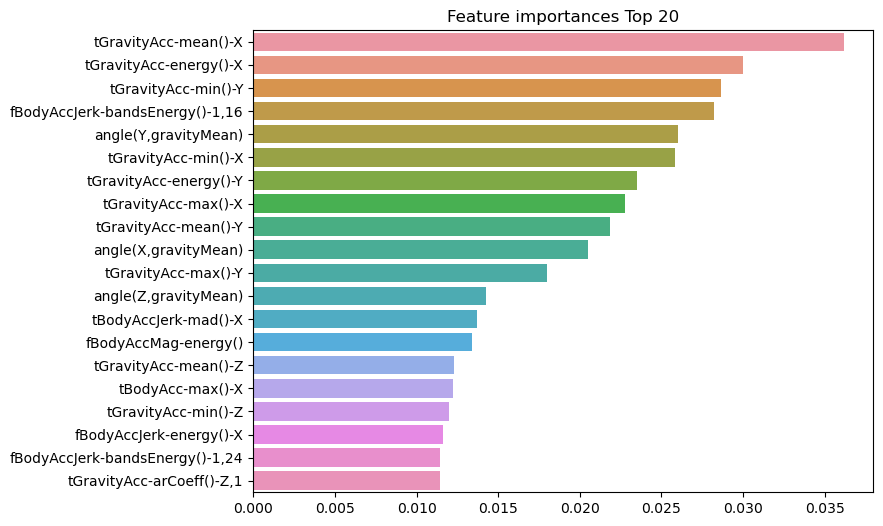

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

ftr_importances_values = rf_clf1.feature_importances_
ftr_importances = pd.Series(ftr_importances_values,index=X_train.columns  )
ftr_top20 = ftr_importances.sort_values(ascending=False)[:20]

plt.figure(figsize=(8,6))
plt.title('Feature importances Top 20')
sns.barplot(x=ftr_top20 , y = ftr_top20.index)
plt.show()